In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

/tmp/ipykernel_6179/307909254.py:13: DtypeWarning: Columns (12,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_observations = pd.read_csv("data/processed/observations.csv")


In [25]:
# Let's get interested by the evolutions of species
species = df_observations["clean_espece"].unique()
evolutionSpecies = {name : pd.Series() for name in species}


for specie in species:

    df_cut = df_observations[df_observations["clean_espece"] == specie]
    evolution = df_cut.groupby("year")["Amount"].sum()

    if 2014 in evolution.keys():
        evolution = evolution.drop(2014)

    evolutionSpecies[specie] = evolution

In [26]:
# Let's identify the species wich are decreasing the most

changeSpecies = {name : pd.NA for name in species}

length = 2025 - 2014 + 1

for specie in changeSpecies:

    evol = evolutionSpecies[specie]

    lastInd = len(evol) - 1
    if lastInd > -1 and evol.iat[0] != 0.0:
        changeSpecies[specie] = 100*(evol.iat[lastInd] - evol.iat[0]) / evol.iat[0]


# Let's get the two species whose population has increased the most and the one who decreased the most




In [27]:

seuil = 250

minEsp, maxEsp = None, None
minChange, maxChange = np.inf, -np.inf 

for specie in species:
    evol = evolutionSpecies[specie]
    rateChange = changeSpecies[specie]

    if len(evol) > 0 and not(pd.isna(rateChange)) and evol.iat[0] >= seuil :

        if rateChange < minChange:
            minChange = rateChange
            minEsp = specie

        if rateChange > maxChange:
            maxChange = rateChange
            maxEsp = specie



The specie of bird that had the biggest increase of its population between 2015 and 2025 is the tourterelle turque
They went from a population of 329.0 in 2015 to 885.0, increasing by 169.00 %.
---------------------------------------------------------------------------------------------
The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the colibri falle-vert
They went from a population of 253.0 in 2015 to 114.0, decreasing by 54.94 %.
---------------------------------------------------------------------------------------------
[214.59090909 205.18181818 195.77272727 186.36363636 176.95454545
 167.54545455 158.13636364 148.72727273 139.31818182 129.90909091
 120.5       ]
Index([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], dtype='int64', name='year')
[ 228.27272727  305.52727273  382.78181818  460.03636364  537.29090909
  614.54545455  691.8         769.05454545  846.30909091  923.56363636
 1000.81818182]
Index([2015, 2016,

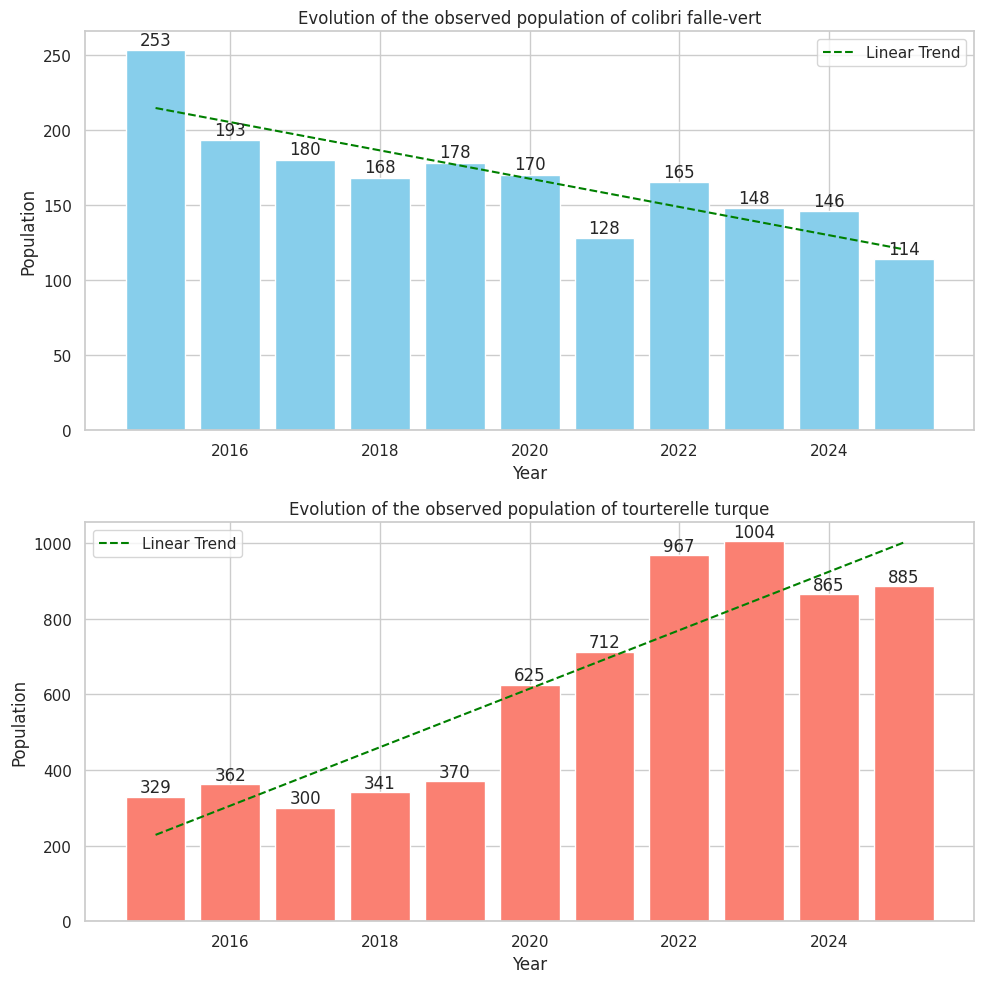

In [28]:
maxEvol = evolutionSpecies[maxEsp]

popBegin = maxEvol.iat[0]
popEnd = maxEvol.iat[len(maxEvol) - 1]
change = changeSpecies[maxEsp]

print(f"The specie of bird that had the biggest increase of its population between 2015 and 2025 is the {maxEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, increasing by {change:.2f} %.")
print("---------------------------------------------------------------------------------------------")


minEvol = evolutionSpecies[minEsp]

popBegin = minEvol.iat[0]
popEnd = minEvol.iat[len(minEvol) - 1]
change = changeSpecies[minEsp]

print(f"The specie of bird that had the biggest decrease of its population between 2015 and 2025 is the {minEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, decreasing by {np.abs(change):.2f} %.")
print("---------------------------------------------------------------------------------------------")

years = maxEvol.keys()
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

def plot_with_trend(ax, x, y, color, title):
    # Bar plot
    ax.bar(x, y, color=color)
    
    X = np.column_stack((np.ones(len(x)), x.values))
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    print(y_pred)
    print(x)
    ax.plot(x, y_pred, color='green', linestyle='--', label='Linear Trend')
    # Annotate bars
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1, int(p.get_height()),
                ha='center', va='bottom')
    
    ax.set_title(title)
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()

# Plot minEvol
plot_with_trend(ax1, years, minEvol, 'skyblue', f'Evolution of the observed population of {minEsp}')

# Plot maxEvol
plot_with_trend(ax2, years, maxEvol, 'salmon', f'Evolution of the observed population of {maxEsp}')

plt.tight_layout()
plt.savefig("figures/evolution_specie.jpeg")
plt.show()


year
2015    21.716741
2016    21.716741
2017    21.716741
2018    21.716741
2019    21.716741
2020    21.716741
2021    21.716741
2022    21.716741
2023    21.716741
2024    21.716741
2025    21.716741
dtype: float64


/tmp/ipykernel_6179/168467018.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=years, y=minEvol, ax=ax1, color='skyblue', ci=None)
/tmp/ipykernel_6179/168467018.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=years, y=maxEvol, ax=ax2, color='salmon', ci=None)


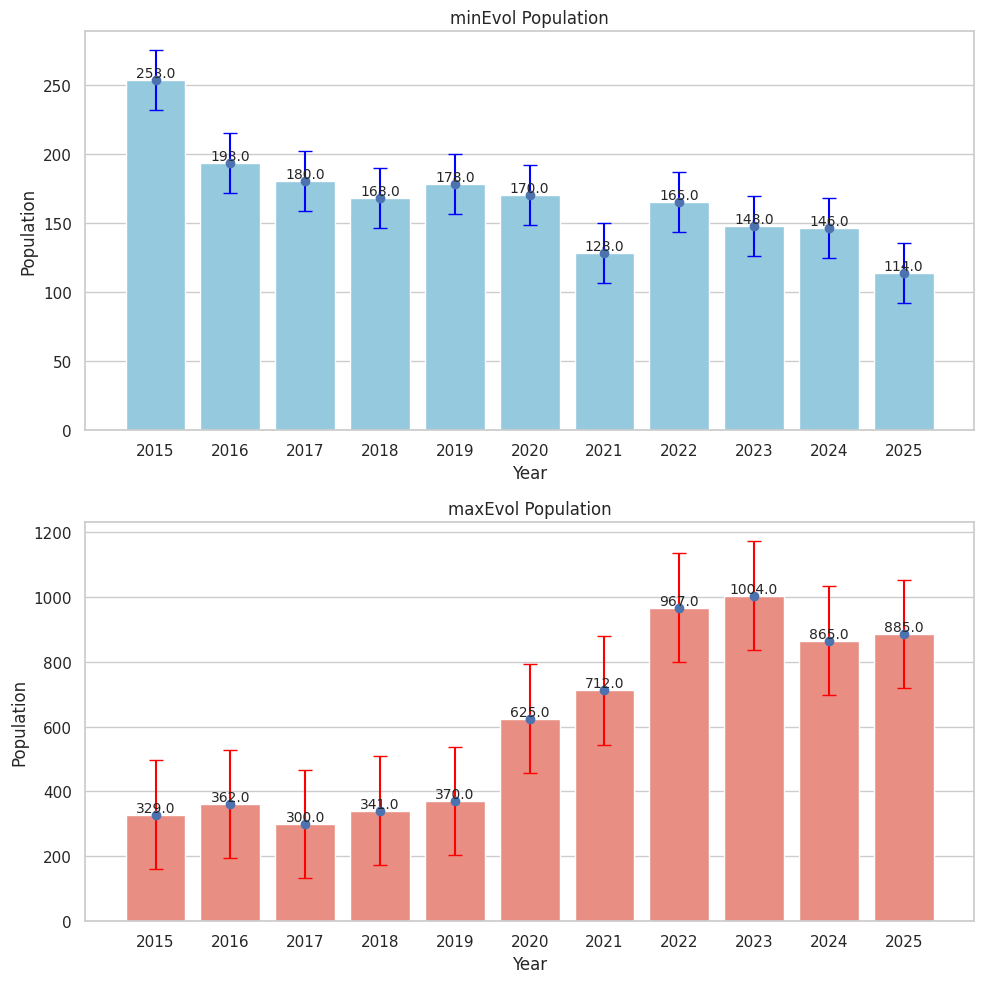

In [43]:
# Now lets' get interested to the COnfidence Intervals for the mean and variance of those two species per year using the bootstrap method

alpha = 0.05


sigmaMinEvol = minEvol.std(ddof=1)
sigmaMaxEvol = maxEvol.std(ddof=1)



n = len(years)

CIMinEvol = pd.Series(index=years, dtype=object)
CIMaxEvol = pd.Series(index=years, dtype=object)

errMinEvols = pd.Series(index = years)
errMaxEvols = pd.Series(index = years)


for year in years:

    mu1 = minEvol[year]
    mu2 = maxEvol[year]

    x_alpha1 = norm.ppf(1 - alpha/2)
    x_alpha2 = norm.ppf(1 - alpha/2)

    
    errMinEvol = x_alpha1 *(sigmaMinEvol / np.sqrt(n))
    errMaxEvol = x_alpha2 *(sigmaMaxEvol / np.sqrt(n))

    CIMinEvol[year] = np.array([mu1 + errMinEvol , mu1 - errMinEvol])
    CIMaxEvol[year] = np.array([mu2 + errMaxEvol , mu2 - errMaxEvol])

    errMinEvols[year] = errMinEvol
    errMaxEvols[year] = errMaxEvol
print(errMinEvols)

   

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# --- minEvol barplot ---
sns.barplot(x=years, y=minEvol, ax=ax1, color='skyblue', ci=None)




ax1.errorbar(x=range(len(years)), y = minEvol, yerr=errMinEvols, fmt='o', ecolor='blue', capsize=5)
ax1.set_title('minEvol Population')
ax1.set_ylabel('Population')
ax1.set_xlabel('Year')

# --- maxEvol barplot ---
sns.barplot(x=years, y=maxEvol, ax=ax2, color='salmon', ci=None)
ax2.errorbar(x=range(len(years)), y = maxEvol, yerr=errMaxEvols, fmt='o', ecolor='red', capsize=5)
ax2.set_title('maxEvol Population')
ax2.set_ylabel('Population')
ax2.set_xlabel('Year')

for i, val in enumerate(minEvol):
    ax1.text(i, int(val), str(val), ha='center', va='bottom', fontsize=10)

for i, val in enumerate(maxEvol):
    ax2.text(i, int(val), str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
